# Homework 2 (66 pts)

## Overview
This homework will focus on checking the global and local spatial autocorrelation and point pattern analysis based on the Airbnb listing in New York City and the underlying socioeconomics. Through this practice, you will review the process of retrieving data from API, building spatial weights from georeferenced data, checking global and local spatial autocorrelation, and conducting point pattern analysis. 

## Grading
Each exercise will be graded based on the following rubrics:
- 2 points. Completed the task, presented the expected results, and codes were well documented and explained.
- 1 point. Completed the task with some disparity from the expected results.
- 0 point. Did not complete the excercise.

## Late submission policy
For late submission, every extra day after the due date will lead to 20% off of your points. Less than a day will be counted as one day. All submissions after the TA team posts the answers will not be accepted.

## 1. Read and Clean Data
### 1.1 Read and Clean Census Tract Data (4 pts)
Homework 1 presented detailed steps of downloading and cleaning census tract data while here you can try Socrata to retrieve the same dataset. Use the following link: https://data.cityofnewyork.us/City-Government/2020-Census-Tracts-Tabular/63ge-mke6 and find the API Endpoint. 
- Specify the BoroName as Manhattan in the url. (2 pts)
- Transform the downloaded dataframe into a geodataframe and set the crs as 4326. (2 pts)

Present the geodataframe (name it as **ct**).

In [1]:
# Graphics
import matplotlib.pyplot as plt
from matplotlib import colors

import seaborn as sns
from pysal.viz import splot
from splot.esda import plot_moran
import contextily as ctx

sns.set_context(context='paper')


# Analysis
import geopandas as gpd
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed
import os
import numpy as np

import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation



## warnings is a module that allows you to filter warnings
import warnings
## we are going to ignore all warnings (so they won't print)
warnings.filterwarnings("ignore")

C:\Users\yujin\anaconda3\envs\gds_py\lib\site-packages\splot\_viz_esda_mpl.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
C:\Users\yujin\anaconda3\envs\gds_py\lib\site-packages\spaghetti\network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries.

In [2]:
# I got the url of the api and saw the information of the columns. The geometry data seems to be an object though.

ct_url = "https://data.cityofnewyork.us/resource/63ge-mke6.json?$where=BoroName ='Manhattan'".replace(" ", "%20")
ct_pd = pd.read_json(ct_url)
ct_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   the_geom    310 non-null    object 
 1   ctlabel     310 non-null    float64
 2   borocode    310 non-null    int64  
 3   boroname    310 non-null    object 
 4   ct2020      310 non-null    int64  
 5   boroct2020  310 non-null    int64  
 6   ntaname     310 non-null    object 
 7   nta2020     310 non-null    object 
 8   cdta2020    310 non-null    object 
 9   cdtaname    310 non-null    object 
 10  geoid       310 non-null    int64  
 11  shape_leng  310 non-null    float64
 12  shape_area  310 non-null    float64
dtypes: float64(3), int64(4), object(6)
memory usage: 31.6+ KB


In [3]:
# I have to change the geometry from an 'object' to a 'geometry' first
from shapely.geometry import shape
ct_pd['the_geom'] = ct_pd['the_geom'].apply(shape)

In [4]:
ct = gpd.GeoDataFrame(ct_pd,
                      geometry='the_geom',
                    crs='EPSG:4326')

In [5]:
ct.head()

,the_geom,ctlabel,borocode,boroname,ct2020,boroct2020,ntaname,nta2020,cdta2020,cdtaname,geoid,shape_leng,shape_area
0,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",1.00,1,Manhattan,100,1000100,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,11023.048501,1.844421e+06
1,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",2.01,1,Manhattan,201,1000201,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4754.495247,9.723121e+05
2,"MULTIPOLYGON (((-73.99022 40.71440, -73.98934 ...",6.00,1,Manhattan,600,1000600,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,6976.286456,2.582705e+06
3,"MULTIPOLYGON (((-73.98837 40.71645, -73.98754 ...",14.01,1,Manhattan,1401,1001401,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,5075.332000,1.006117e+06
4,"MULTIPOLYGON (((-73.98507 40.71908, -73.98423 ...",14.02,1,Manhattan,1402,1001402,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,4459.156019,1.226206e+06


### 1.2 Read and Clean Airbnb Listing Data (2 pts)
Similar to homework 1, you are required to download and clean the Airbnb listing data and wrap all of them into one cell. Use the same link in homework 1 to download the listing data in New York City.
- Change *price* column type as float.
- Transform the dataframe into geodataframe using the latitude-longitude pairs.
- Spatial join **ct** with only *geoid*, *boroname* and *the_geom* columns to the listing geodataframe.

You should only have the listings in Manhattan. Present your geodataframe **listing** below.

In [6]:
# enter your codes here
listing_1 = pd.read_csv('listing_raw.csv')
listing_1['price'] = listing_1['price'].str.replace(',', "")
listing_1['price'] = listing_1['price'].str.replace('$', "")
listing_1['price'] = listing_1['price'].astype('float')


In [7]:
listing_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41533 entries, 0 to 41532
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            41533 non-null  int64  
 1   listing_url                                   41533 non-null  object 
 2   scrape_id                                     41533 non-null  int64  
 3   last_scraped                                  41533 non-null  object 
 4   source                                        41533 non-null  object 
 5   name                                          41520 non-null  object 
 6   description                                   40747 non-null  object 
 7   neighborhood_overview                         24089 non-null  object 
 8   picture_url                                   41533 non-null  object 
 9   host_id                                       41533 non-null 

In [8]:
listing_geo = gpd.GeoDataFrame (listing_1, 
                                geometry = gpd.points_from_xy(listing_1.longitude, listing_1.latitude, crs="EPSG:4326"))
                                

In [9]:
listing = gpd.tools.sjoin(ct[['geoid', 'boroname', 'the_geom']], listing_geo, how='left')

In [10]:
listing.head()

,geoid,boroname,the_geom,index_right,id,listing_url,scrape_id,last_scraped,source,name,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,36061000100,Manhattan,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36061000201,Manhattan,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",16480.0,31439428.0,https://www.airbnb.com/rooms/31439428,2.022120e+13,2022-12-05,previous scrape,"Manhattan: large 3bed/2bath, new reno, central...",...,NaN,NaN,NaN,NaN,f,1.0,0.0,0.0,1.0,NaN
1,36061000201,Manhattan,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",9463.0,15815905.0,https://www.airbnb.com/rooms/15815905,2.022120e+13,2022-12-05,city scrape,Backyard Bamboo Home at L.E.S,...,4.90,4.74,4.27,NaN,f,1.0,1.0,0.0,0.0,1.19
1,36061000201,Manhattan,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",13419.0,24306539.0,https://www.airbnb.com/rooms/24306539,2.022120e+13,2022-12-05,city scrape,New Chic Designer's Bedroom,...,4.76,4.72,4.60,NaN,t,2.0,0.0,2.0,0.0,4.09
1,36061000201,Manhattan,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",6086.0,9528920.0,https://www.airbnb.com/rooms/9528920,2.022120e+13,2022-12-05,previous scrape,"Quiet, Clean, Lit @ LES & Chinatown",...,4.33,4.67,4.50,NaN,f,1.0,0.0,1.0,0.0,0.07


### 1.3 Retrieve American Community Survey (ACS) Data (6 pts)
The 3rd dataset is from American Community Survey. You can first check with "2019 ACS Table List" from [ACS table](https://www.census.gov/programs-surveys/acs/technical-documentation/table-shells.2019.html#list-tab-LO1F1MU1CQP3YOHD2T) and find the median household income code as **B19013_001**. Use *cenpy* module to download the household income information in New York City and use census tract level as the geographic unit. Save the data as **acs_data** and name the column for household income as *median_hh_inc*. Present the information of **acs_data**. (2 pts)

In [11]:
import cenpy
acs_cp= cenpy.products.ACS()
acs_data = acs_cp.from_place('New York, NY',
                                level='tract',
                                variables=['B19013_001'])

Matched: New York, NY to New York city within layer Incorporated Places


In [12]:
acs_data.head()

,GEOID,geometry,B19013_001E,state,county,tract
0,36085020801,"POLYGON ((-8262278.990 4946228.710, -8261996.3...",100543.0,36,085,020801
1,36085017012,"POLYGON ((-8257822.870 4945745.990, -8257700.4...",89273.0,36,085,017012
2,36085031901,"POLYGON ((-8256173.450 4957701.750, -8256171.1...",21250.0,36,085,031901
3,36085031902,"POLYGON ((-8256709.900 4959461.880, -8256698.5...",46118.0,36,085,031902
4,36085014606,"POLYGON ((-8254594.160 4948740.120, -8254529.4...",103825.0,36,085,014606


In [13]:
acs_data = acs_data.rename(columns={'B19013_001E' : 'median_hh_inc'})
acs_data.head()

,GEOID,geometry,median_hh_inc,state,county,tract
0,36085020801,"POLYGON ((-8262278.990 4946228.710, -8261996.3...",100543.0,36,085,020801
1,36085017012,"POLYGON ((-8257822.870 4945745.990, -8257700.4...",89273.0,36,085,017012
2,36085031901,"POLYGON ((-8256173.450 4957701.750, -8256171.1...",21250.0,36,085,031901
3,36085031902,"POLYGON ((-8256709.900 4959461.880, -8256698.5...",46118.0,36,085,031902
4,36085014606,"POLYGON ((-8254594.160 4948740.120, -8254529.4...",103825.0,36,085,014606


In [14]:
acs_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2066 entries, 0 to 2065
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GEOID          2066 non-null   object  
 1   geometry       2066 non-null   geometry
 2   median_hh_inc  2006 non-null   float64 
 3   state          2066 non-null   object  
 4   county         2066 non-null   object  
 5   tract          2066 non-null   object  
dtypes: float64(1), geometry(1), object(4)
memory usage: 113.0+ KB


Notice that *median_hh_inc* column includes null values. Replace all null values with the mean of the median household income. (2 pts)

In [15]:
acs_data['median_hh_inc'].mean()

70171.94317048854

In [16]:
acs_data['median_hh_inc']=acs_data['median_hh_inc'].fillna(acs_data['median_hh_inc'].mean())

In [17]:
acs_data['median_hh_inc'].info()

<class 'pandas.core.series.Series'>
Int64Index: 2066 entries, 0 to 2065
Series name: median_hh_inc
Non-Null Count  Dtype  
--------------  -----  
2066 non-null   float64
dtypes: float64(1)
memory usage: 32.3 KB


In [18]:
acs_data['median_hh_inc'] = acs_data['median_hh_inc'].astype('float')

In [19]:
acs_data['median_hh_inc'].info()

<class 'pandas.core.series.Series'>
Int64Index: 2066 entries, 0 to 2065
Series name: median_hh_inc
Non-Null Count  Dtype  
--------------  -----  
2066 non-null   float64
dtypes: float64(1)
memory usage: 32.3 KB


Plot the median household income by census tract. Five quantiles are used here with *GnBu* color ramp. Remember to add:
- Title
- Legend
- X-Y axis names

properly to the map. (2 pts)

<AxesSubplot: title={'center': '2022 New York City Census Tract: Median Household Income'}, xlabel='longitude', ylabel='latitude'>

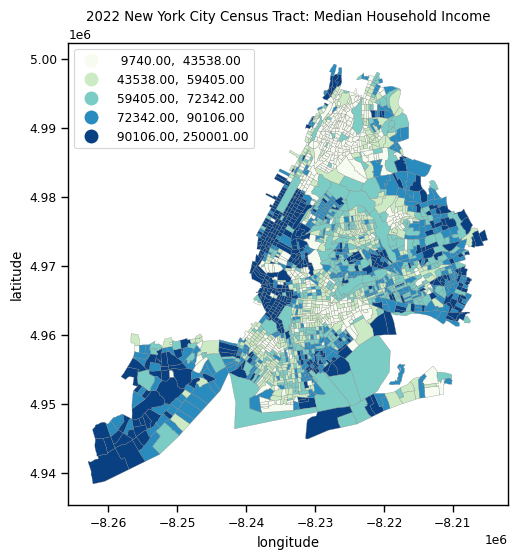

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.title('2022 New York City Census Tract: Median Household Income')
plt.xlabel('longitude')
plt.ylabel('latitude')

acs_data.plot(ax=ax, column = 'median_hh_inc',
                    legend=True,
                    scheme= 'Quantiles',
                     k=5,
                    cmap='GnBu',
                    edgecolor = 'grey',
                    linewidth=0.2,
                    legend_kwds={'loc': 'upper left'})

## 2. Data Analysis & Visualization
### 2.1 Create Spatial Weights (12 pts)
ACS data is firstly analyzed. Create a spatial weight, *wq*, with *Queen* method and standardize the spatial weight. (2 pts)

In [21]:
from pysal.lib import cg as geometry

## warnings is a module that allows you to filter warnings
import warnings
## we are going to ignore all warnings (so they won't print)
warnings.filterwarnings("ignore")

In [22]:
from pysal.lib import weights
wq = weights.contiguity.Queen.from_dataframe(acs_data)

Since *median_hh_inc* column will be used repetitively, store this column in variable *y*. Therefore, *ylag* is generated from *y* to store the spatial lags of *median_hh_inc*. (2 pts)

In [23]:
acs_data['ylag']=weights.spatial_lag.lag_spatial(
    wq, acs_data['median_hh_inc'])

In [24]:
y = acs_data['median_hh_inc']
ylag= weights.spatial_lag.lag_spatial(
    wq, y)

To compare *y* with *ylag* visually, you can create two plots side by side. 
- Both maps should have 5 quantiles of *y* and *ylag* respectively with your choice of color ramp. (2 pts)
- Both maps should have proper titles and legends. (2 pts)
- Remove axis for both maps. (2 pts)

In [25]:
import contextily as ctx

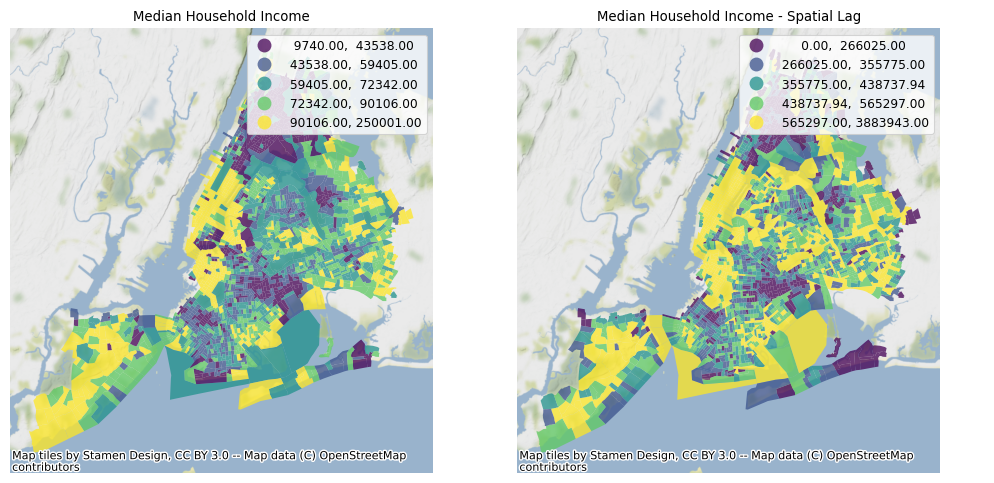

In [26]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

acs_data.plot(
    column="median_hh_inc",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("Median Household Income")
ctx.add_basemap(
    ax1,
    crs=acs_data.crs,
    source=ctx.providers.Stamen.TerrainBackground,
)

acs_data.plot(
    column="ylag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("Median Household Income - Spatial Lag")
ctx.add_basemap(
    ax2,
    crs=acs_data.crs,
    source=ctx.providers.Stamen.TerrainBackground,
)

plt.show()

Why do the two maps look different? How do you interpret the difference? (2 pts)

### 2.2 Global Spatial Correlation (8 pts)
By plotting median household income above, you will have some ideas about where the affluent and the less affluent people live. To verify your hypothesis, you can try to find how they are correlated with their neighbors globally.

Firstly, create a boolean list *yb* if the census tract's median household income (*y*) exceeds the median median household income in Manhattan (median of *y*). (2 pts)

In [27]:
y = acs_data['median_hh_inc'].median()

In [28]:
acs_data['yb_rough'] =((acs_data["median_hh_inc"]> acs_data['median_hh_inc'].median()).astype(int))
acs_data['yb_rough']

0       1
1       1
2       0
3       0
4       1
       ..
2061    1
2062    1
2063    1
2064    1
2065    1
Name: yb_rough, Length: 2066, dtype: int32

Next, create a new column *yb* in **acs_data** where *0 low* means the census tract's median household income is below the median of *y* and *1 high* means the rest. (2 pts)

In [29]:
acs_data['yb'] =""

In [30]:
acs_data.loc[acs_data['yb_rough'] == 1 ,'yb'] = '1 high'
acs_data.loc[acs_data['yb_rough'] == 0 ,'yb'] = '0 low'
acs_data['yb']

0       1 high
1       1 high
2        0 low
3        0 low
4       1 high
         ...  
2061    1 high
2062    1 high
2063    1 high
2064    1 high
2065    1 high
Name: yb, Length: 2066, dtype: object

Plot census tracts whose household income are above the median as black and those below as white. (2 pts)

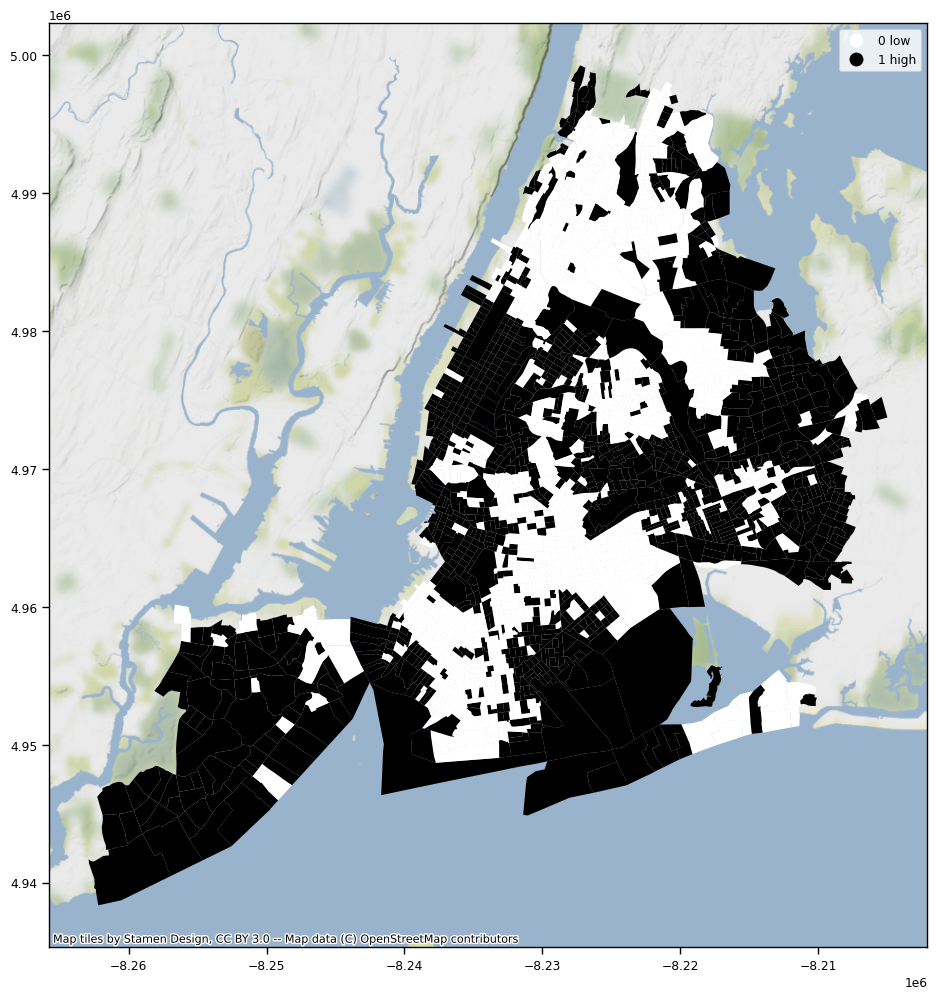

In [31]:
f, ax = plt.subplots(1, figsize=(12, 12,))
base = acs_data.plot(column='yb',
                figsize=(12,12),
                legend=True,
                cmap='Greys',
               ax=ax
)

ctx.add_basemap(
    ax=ax,
    crs=acs_data.crs,
    source=ctx.providers.Stamen.TerrainBackground,
)

Do you think a binary map is better at showing spatial disparity than the quantile map in Q2.1? (2 pts)

### 2.3 Moran's I (8 pts)
By looking at the maps, you are convinced that wealth is not distributed across NYC space evenly. Moran's I will provide you a statistical tool to further testify your hypothesis. 

To create a Moran Plot, you should first calculate the difference between the median household income and its mean. Then repeat the step for the spatial lags of the median household income. Add these two lists to **acs_data** as column *y_std* and *ylag_std*. (2 pts)
Then use seaborn module to make a scatter plot using the two columns. Add x and y axis names and tiles to the plot. (2 pts)

In [32]:
acs_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2066 entries, 0 to 2065
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GEOID          2066 non-null   object  
 1   geometry       2066 non-null   geometry
 2   median_hh_inc  2066 non-null   float64 
 3   state          2066 non-null   object  
 4   county         2066 non-null   object  
 5   tract          2066 non-null   object  
 6   ylag           2066 non-null   float64 
 7   yb_rough       2066 non-null   int32   
 8   yb             2066 non-null   object  
dtypes: float64(2), geometry(1), int32(1), object(5)
memory usage: 153.3+ KB


In [33]:
acs_data["ylag"] = weights.spatial_lag.lag_spatial(
    wq, acs_data["median_hh_inc"]
)

In [34]:
acs_data["y_std"] = (acs_data["median_hh_inc"] - acs_data["median_hh_inc"].mean())/acs_data["median_hh_inc"].std()
acs_data["ylag_std"] = (
    acs_data["ylag"] - acs_data["ylag"].mean()
)/acs_data["ylag"].std()

In [35]:
acs_data.head()

,GEOID,geometry,median_hh_inc,state,county,tract,ylag,yb_rough,yb,y_std,ylag_std
0,36085020801,"POLYGON ((-8262278.990 4946228.710, -8261996.3...",100543.0,36,085,020801,398455.0,1,1 high,0.907790,-0.164705
1,36085017012,"POLYGON ((-8257822.870 4945745.990, -8257700.4...",89273.0,36,085,017012,718632.0,1,1 high,0.570930,1.250372
2,36085031901,"POLYGON ((-8256173.450 4957701.750, -8256171.1...",21250.0,36,085,031901,214377.0,0,0 low,-1.462276,-0.978269
3,36085031902,"POLYGON ((-8256709.900 4959461.880, -8256698.5...",46118.0,36,085,031902,103849.0,0,0 low,-0.718972,-1.466766
4,36085014606,"POLYGON ((-8254594.160 4948740.120, -8254529.4...",103825.0,36,085,014606,489818.0,1,1 high,1.005889,0.239089


In [36]:
wq.transform = "R"
moran = esda.moran.Moran(acs_data["median_hh_inc"], wq)

('WARNING: ', 229, ' is an island (no neighbors)')


In [37]:
moran.I

0.6594848030500569

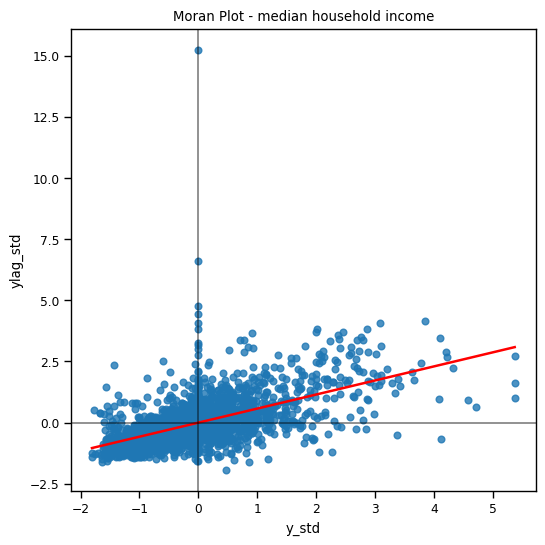

In [38]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="y_std",
    y="ylag_std",
    ci=None,
    data=acs_data,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - median household income")
plt.show()

#positive slope = positive spatial autocorrelation

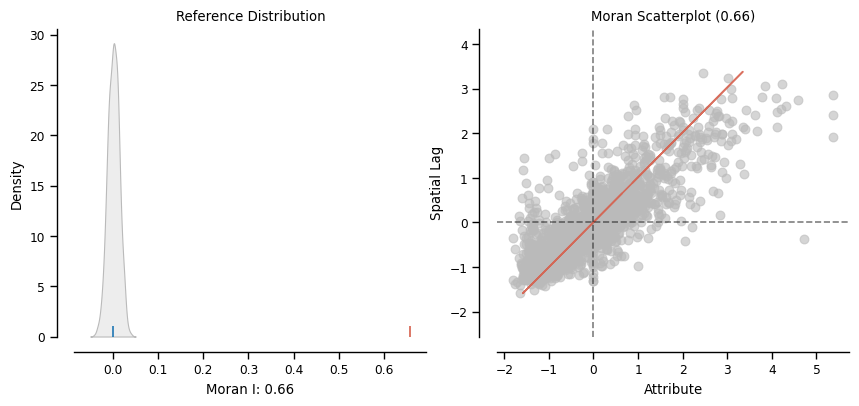

In [39]:
plot_moran(moran);

How do you interpret the Moran's Plot? Does it indicate a strong or weak autocorrelation? (2 pts)

In [40]:
# The Moran's Plot indicates that compared the random sample, there is a higher mean when we take into consideration randomness. The values from the scatterplot can be seen to be 
# conglomerated around (0,0).

What is the value of your Moran's I? (2 pts)

In [41]:
#Moran's I turns out to be 0.66

### 2.4 Local Spatial Autocorrelation (8 pts)
The significant value of Moran's I confirms that the spatial distribution of NYC's wealth is highly uneven. But where are the richest neighborhoods and where are the poorest?

Firstly you can generate local Moran's I and name this variable as *li*. (2 pts)

In [42]:
li= esda.moran.Moran_Local(acs_data["median_hh_inc"], wq)

Based on the significance value (less than 0.05), create a new column *cl* to **acs_data** with values of *0 ns*, *1 hot pot*, *2 doughnut*, *3 cold spot*, and *4 diamond*. (2 pts)
As the names indicate, Hot Spot is the neighborhoods with high household income and Cold Spot is the neighborhoods with low household income. Doughnut is the low-income neighborhoods surrounded by high-income neighbors while Diamond is the high-income neighborhoods surrounded by low-income neighbors.

In [43]:
# Assign pseudo P-values to `db`
acs_data["p-sim"] = li.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (li.p_sim < 0.05)
# Assign significance flag to `db`
acs_data["sig"] = sig
# Print top of the table to inspect
acs_data[["sig", "p-sim"]].head()

,sig,p-sim
0,0,0.069
1,1,0.017
2,0,0.428
3,0,0.204
4,0,0.058


In [44]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = li.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
acs_data["labels"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=acs_data.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
acs_data["labels"].head()

0    Non-Significant
1                 HH
2    Non-Significant
3    Non-Significant
4    Non-Significant
Name: labels, dtype: object

In [45]:
acs_data["labels"].value_counts()

Non-Significant    1338
LL                  452
HH                  238
LH                   21
HL                   17
Name: labels, dtype: int64

In [46]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = li.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "ns",
    1: "1 hot spot",
    2: "2 doughnut",
    3: "3 cold spot",
    4: "4 diamond",
}
# Create column in `cl` with labels for each polygon
acs_data["cl"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=acs_data.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
acs_data["cl"].head()

0            ns
1    1 hot spot
2            ns
3            ns
4            ns
Name: cl, dtype: object

In [47]:
acs_data

,GEOID,geometry,median_hh_inc,state,county,tract,ylag,yb_rough,yb,y_std,ylag_std,p-sim,sig,labels,cl
0,36085020801,"POLYGON ((-8262278.990 4946228.710, -8261996.3...",100543.0,36,085,020801,398455.00000,1,1 high,0.907790,-0.164705,0.069,0,Non-Significant,ns
1,36085017012,"POLYGON ((-8257822.870 4945745.990, -8257700.4...",89273.0,36,085,017012,718632.00000,1,1 high,0.570930,1.250372,0.017,1,HH,1 hot spot
2,36085031901,"POLYGON ((-8256173.450 4957701.750, -8256171.1...",21250.0,36,085,031901,214377.00000,0,0 low,-1.462276,-0.978269,0.428,0,Non-Significant,ns
3,36085031902,"POLYGON ((-8256709.900 4959461.880, -8256698.5...",46118.0,36,085,031902,103849.00000,0,0 low,-0.718972,-1.466766,0.204,0,Non-Significant,ns
4,36085014606,"POLYGON ((-8254594.160 4948740.120, -8254529.4...",103825.0,36,085,014606,489818.00000,1,1 high,1.005889,0.239089,0.058,0,Non-Significant,ns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,36081068200,"POLYGON ((-8210354.790 4963345.130, -8210303.5...",89000.0,36,081,068200,294034.00000,1,1 high,0.562770,-0.626211,0.099,0,Non-Significant,ns
2062,36081038400,"POLYGON ((-8209957.050 4967415.210, -8209906.6...",75114.0,36,081,038400,631901.00000,1,1 high,0.147718,0.867049,0.081,0,Non-Significant,ns
2063,36081059000,"POLYGON ((-8208826.490 4968457.410, -8208815.6...",75750.0,36,081,059000,484982.00000,1,1 high,0.166728,0.217716,0.066,0,Non-Significant,ns
2064,36081061800,"POLYGON ((-8208676.320 4964872.740, -8208537.3...",81406.0,36,081,061800,311385.00000,1,1 high,0.335786,-0.549526,0.069,0,Non-Significant,ns


In [48]:
from splot import esda as esdaplot

Plot the four types of census tracts with lightgrey to *0 ns*, red to *1 hot pot*, lightblue to *2 doughnut*, blue to *3 cold spot*, and pink to *4 diamond*. Add legend and titles to the plot. (2 pts)

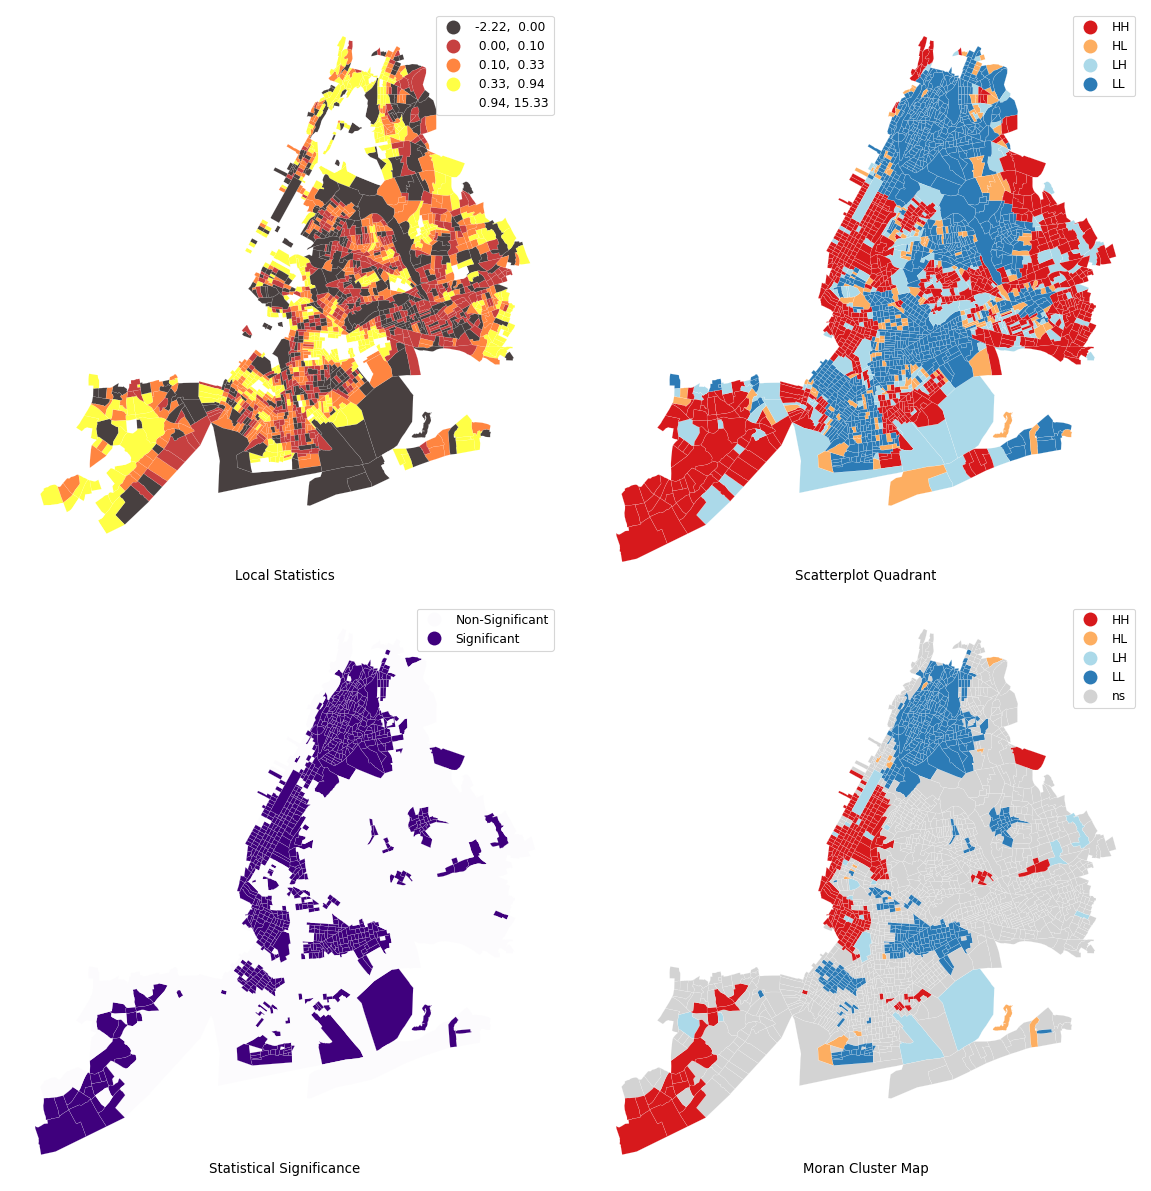

In [49]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
colors = {'ns':'tab:lightgrey', 'HH':'tab:red', 'HL':'tab:pink', 'LH':'tab:lightblue', 'LL':'tab:blue'}

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
acs_data.assign(
    Is=li.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="hot",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(li, acs_data, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (li.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=acs_data.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
acs_data.assign(
    cl= labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Purples",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(li, acs_data, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

How do you interpret the four types of colored regions under the NYC context? Why do some parks apprear as "doughnuts"? (2 pts)

### 2.5 Point Pattern Analysis (18 pts)
With an image of wealth distribution across NYC, now you can move to the Airbnb listing to see if locations of the short-term rental listing have any relationship with their neighborhoods.

Map all the listing in Manhattan by their coordinates and show the density on latitudes and longitudes respectively. (2 pts)

In [50]:
import numpy
import pandas as pd
import geopandas as gpd
import pysal

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

sns.set_context(context='paper')

from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed



from sklearn.cluster import DBSCAN


import warnings

warnings.filterwarnings("ignore")

To generate a density map for points data, you should firstly assign those points to different areal units. Hexagon is one of the most used units. For Manhattan, you can generate and add hexbin with 50 hexagons in each dimension without bordorline and with half transparency. (2 pts) Add a base map and colorbar and remove axes. (2 pts) Show your map below.

In [51]:
#for some reason my index was off so let me just reset it
listing.reset_index()

,index,geoid,boroname,the_geom,index_right,id,listing_url,scrape_id,last_scraped,source,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,36061000100,Manhattan,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,36061000201,Manhattan,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",16480.0,31439428.0,https://www.airbnb.com/rooms/31439428,2.022120e+13,2022-12-05,previous scrape,...,NaN,NaN,NaN,NaN,f,1.0,0.0,0.0,1.0,NaN
2,1,36061000201,Manhattan,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",9463.0,15815905.0,https://www.airbnb.com/rooms/15815905,2.022120e+13,2022-12-05,city scrape,...,4.90,4.74,4.27,NaN,f,1.0,1.0,0.0,0.0,1.19
3,1,36061000201,Manhattan,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",13419.0,24306539.0,https://www.airbnb.com/rooms/24306539,2.022120e+13,2022-12-05,city scrape,...,4.76,4.72,4.60,NaN,t,2.0,0.0,2.0,0.0,4.09
4,1,36061000201,Manhattan,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",6086.0,9528920.0,https://www.airbnb.com/rooms/9528920,2.022120e+13,2022-12-05,previous scrape,...,4.33,4.67,4.50,NaN,f,1.0,0.0,1.0,0.0,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17331,309,36061000202,Manhattan,"MULTIPOLYGON (((-73.98237 40.70554, -73.98246 ...",303.0,222913.0,https://www.airbnb.com/rooms/222913,2.022120e+13,2022-12-05,city scrape,...,4.88,4.42,4.65,NaN,f,1.0,1.0,0.0,0.0,1.71
17332,309,36061000202,Manhattan,"MULTIPOLYGON (((-73.98237 40.70554, -73.98246 ...",5886.0,9343350.0,https://www.airbnb.com/rooms/9343350,2.022120e+13,2022-12-05,previous scrape,...,5.00,4.33,5.00,NaN,f,2.0,1.0,1.0,0.0,0.04
17333,309,36061000202,Manhattan,"MULTIPOLYGON (((-73.98237 40.70554, -73.98246 ...",5194.0,8152985.0,https://www.airbnb.com/rooms/8152985,2.022120e+13,2022-12-05,previous scrape,...,4.75,4.50,4.50,NaN,f,4.0,1.0,3.0,0.0,0.06
17334,309,36061000202,Manhattan,"MULTIPOLYGON (((-73.98237 40.70554, -73.98246 ...",8355.0,13643488.0,https://www.airbnb.com/rooms/13643488,2.022120e+13,2022-12-05,previous scrape,...,NaN,NaN,NaN,NaN,f,1.0,0.0,1.0,0.0,NaN


In [52]:
listing.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [53]:
listing.head()

,geoid,boroname,the_geom,index_right,id,listing_url,scrape_id,last_scraped,source,name,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,36061000100,Manhattan,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36061000201,Manhattan,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",16480.0,31439428.0,https://www.airbnb.com/rooms/31439428,2.022120e+13,2022-12-05,previous scrape,"Manhattan: large 3bed/2bath, new reno, central...",...,NaN,NaN,NaN,NaN,f,1.0,0.0,0.0,1.0,NaN
1,36061000201,Manhattan,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",9463.0,15815905.0,https://www.airbnb.com/rooms/15815905,2.022120e+13,2022-12-05,city scrape,Backyard Bamboo Home at L.E.S,...,4.90,4.74,4.27,NaN,f,1.0,1.0,0.0,0.0,1.19
1,36061000201,Manhattan,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",13419.0,24306539.0,https://www.airbnb.com/rooms/24306539,2.022120e+13,2022-12-05,city scrape,New Chic Designer's Bedroom,...,4.76,4.72,4.60,NaN,t,2.0,0.0,2.0,0.0,4.09
1,36061000201,Manhattan,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",6086.0,9528920.0,https://www.airbnb.com/rooms/9528920,2.022120e+13,2022-12-05,previous scrape,"Quiet, Clean, Lit @ LES & Chinatown",...,4.33,4.67,4.50,NaN,f,1.0,0.0,1.0,0.0,0.07


In [59]:
#it seems that the nan values are causing errors, so let me drop nan values from longitude and latitude
listing = listing[listing['longitude'].isna()==False]
listing = listing[listing['latitude'].isna()==False]

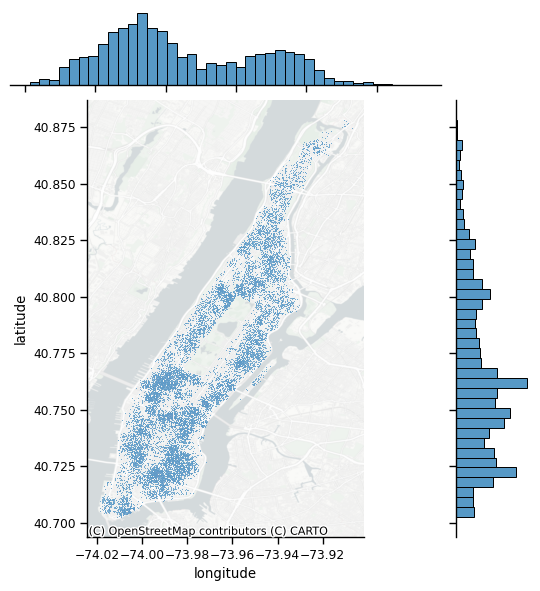

In [60]:
# Generate scatter plot, this is just for my reference, so I can get a raw idea of what the scatter plots would look like
joint_axes = sns.jointplot(
    x="longitude", y="latitude", data=listing, s=0.5,
)
ctx.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=ctx.providers.CartoDB.PositronNoLabels,
);

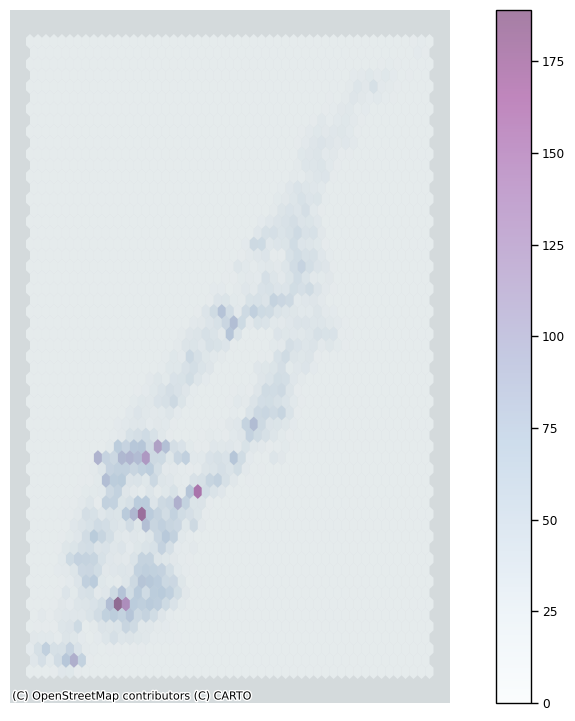

In [61]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    x=listing["longitude"],
    y= listing["latitude"],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap="BuPu",
)
# Add basemap
ctx.add_basemap(
    ax, source=ctx.providers.CartoDB.Positron
)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()



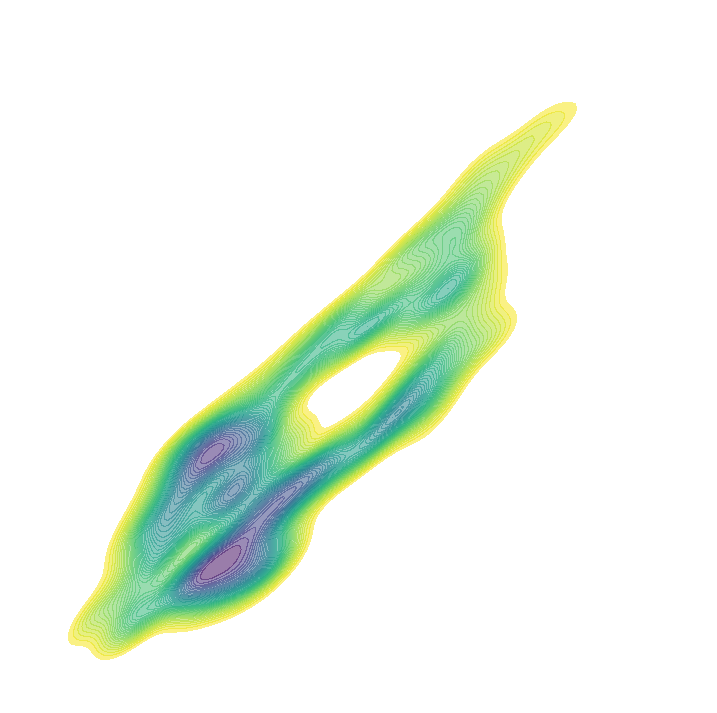

In [62]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
sns.kdeplot(
    data = listing,
    x=listing["longitude"],
    y=listing["latitude"],
    n_levels=50,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Add basemap
ctx.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=ctx.providers.CartoDB.PositronNoLabels,
);
# Remove axes
ax.set_axis_off()



Find out the mean center (2 pts), median center (2 pts) and standardized ellipse of the Manhattan Airbnb listing. Legend and axis names should be added.

In [63]:
from pointpats import centrography

In [64]:
mean_center = centrography.mean_center(listing[["longitude", "latitude"]])
med_center = centrography.euclidean_median(listing[["longitude", "latitude"]])

In [65]:
major, minor, rotation = centrography.ellipse(listing[["longitude", "latitude"]])

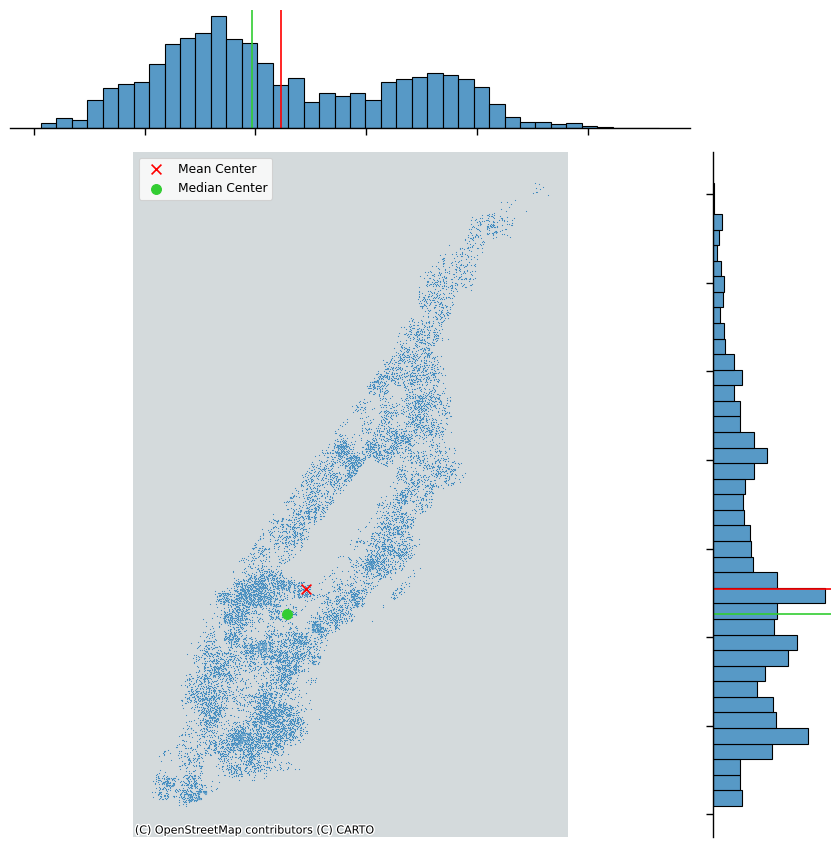

In [66]:
# Generate scatter plot
joint_axes = sns.jointplot(
    x="longitude", y="latitude", data=listing, s=0.75, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color="red", marker="x", s=50, label="Mean Center"
)
joint_axes.ax_marg_x.axvline(mean_center[0], color="red")
joint_axes.ax_marg_y.axhline(mean_center[1], color="red")
# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center,
    color="limegreen",
    marker="o",
    s=50,
    label="Median Center"
)
joint_axes.ax_marg_x.axvline(med_center[0], color="limegreen")
joint_axes.ax_marg_y.axhline(med_center[1], color="limegreen")
# Legend
joint_axes.ax_joint.legend()
# Add basemap
ctx.add_basemap(
    joint_axes.ax_joint, source=ctx.providers.CartoDB.Positron
)
# Clean axes
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

In [67]:
#this would be the longtidue, latitude info for the median center
med_center

array([-73.98068591,  40.75646096])

In [68]:
mean_center

array([-73.97545127,  40.76366734])

Why do the mean and median centers differ? (2 pts)

The difference between the mean and the median is a result of the skewness and location of clusters. Just like when we have exams and the median is usually higher than the mean
if there are students on the far low end and the majority are clustered on the higher end, locational median and mean can also differ as a result from how the clusters are formed.

Generate a quadrat count map based on the listing. In each quadrat, the number of listings should be shown. (2 pts)

In [ ]:
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)

In [ ]:
coordinates = listing[["longitude", "latitude"]].values

In [ ]:
#let me just make sure there aren't any nan values or null values in the coordinates
coordinates

In [ ]:
qstat = QStatistic(coordinates)
qstat.plot()

From the Quadrat Count figure, which areas have the densest Airbnbs? Provide some hypotheses for why this might be the case. (2 pts)

In [ ]:
The lower west side seems to have the densest Airbnb availability. This may be becasue of the fact that tourist attractions are conglomerated there like the Statue of Libery, 
MoMA, and Times Square should be all in the lower left corner. 

What is the p-value of a chi-squared test? How do you interpret the value? (2 pts)

In [ ]:
qstat.chi2_pvalue

In [ ]:
The p-value is equal to 0, indicating the probability of randomness is 0. This also means that we fail to reject the null hypothesis and the data is statistically significant, 
even at the 99% confidence interval.